In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import os
from helper import *

In [2]:
# enter resolution of grid in meters
grid_resolution=4000
# add the directory which contains all species data here
# For example, if the species data is in "D:\hotspot mapping\Data\AMPHIBIANS\AMPHIBIANS\AMPHIBIANS.shp", then directory = "D:\hotspot mapping\Data"
directory = "D:\hotspot mapping\Data"
species_list=[x[1] for x in os.walk(directory)][0]
species_filepath_dict={species:os.path.join(directory,species,species,"{}.shp".format(species)) for species in species_list}

In [3]:
# get the area of interest from a geojson file
cr_polygon = gpd.read_file('D:\hotspot mapping\Data\CR_Crop2.geojson').geometry[0]

In [4]:
final_dict={}
# generate grid
grid = create_grid(resolution=grid_resolution, target_polygon=cr_polygon)
for species, file_path in species_filepath_dict.items():
    species_geo = filter_species(path= file_path, target_polygon=cr_polygon)
    species_count = count_species(species_geo, grid)
    # plot_abundance(species_count,species_name=species)
    final_dict['count_{}'.format(species)]=species_count
    print("{} done".format(species))
    # break
final_df = gpd.GeoDataFrame(final_dict)

AMPHIBIANS done
MAMMALS done
REPTILES done


C:\Users\Jinze Wang\AppData\Local\Temp\ipykernel_6160\3818041554.py:4: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  final_df['geometry']=grid


Text(0.5, 1.0, 'Species Abundance in CR')

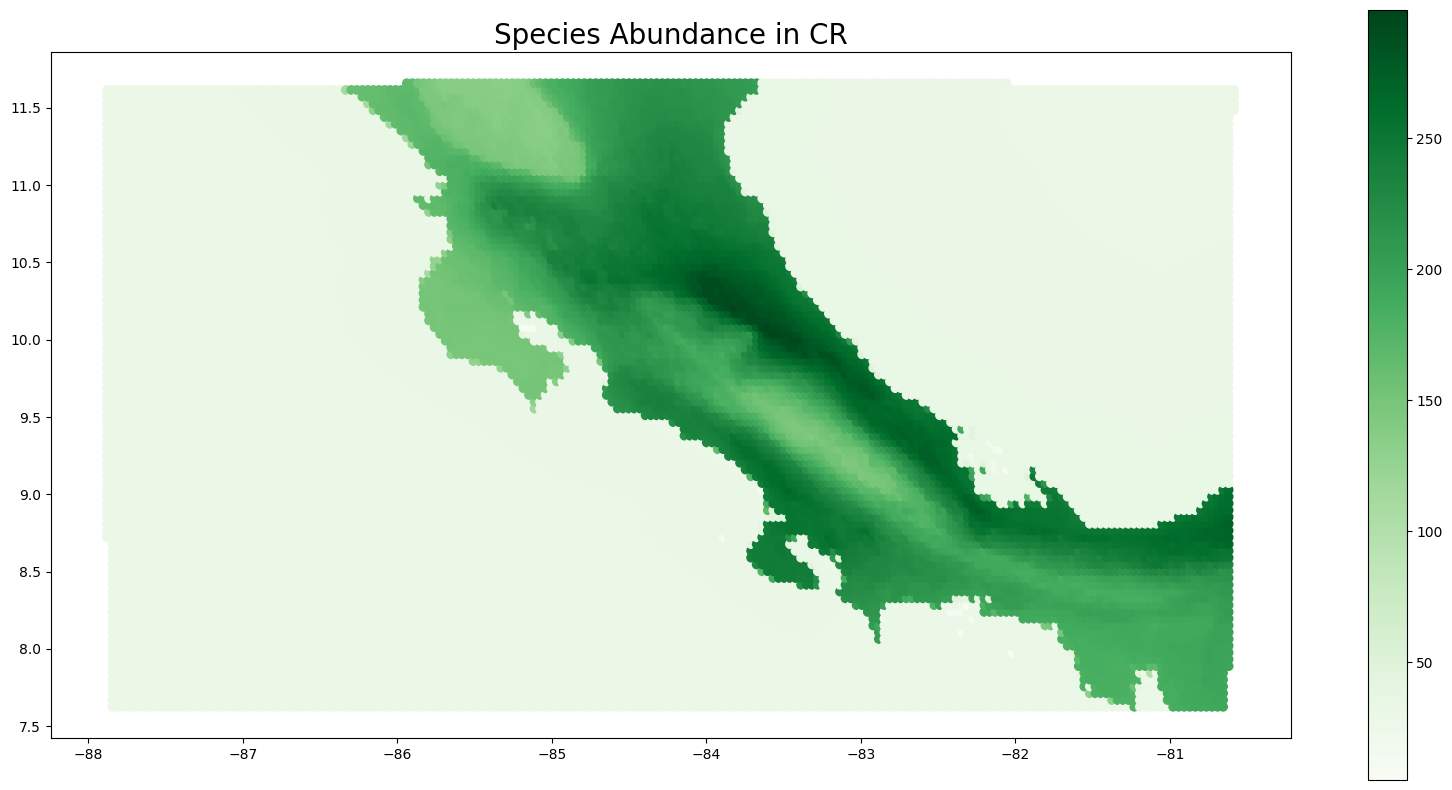

In [5]:
# get the sum of all species
final_df['species_count']=final_df.sum(axis=1)
# add the grid to the dataframe
final_df['geometry']=grid
# convert geometry to lat/lon
final_df['lon'] = final_df['geometry'].x
final_df['lat'] = final_df['geometry'].y
# plot the total species count
fig, ax = plt.subplots(figsize=(20,10))
# gpd.GeoSeries(cr_polygon).plot(ax=ax, color='white', edgecolor='black')
# # plot costa rica map
# cr_map=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).query('name == "Costa Rica"')
# cr_map.plot(ax=ax, color='white', edgecolor='black')
# use a colormap to plot the species count
final_df.plot(ax=ax, column='species_count', legend=True, cmap='Greens')
# set the title
ax.set_title('Species Abundance in CR', fontsize=20)

In [6]:
final_df

,count_AMPHIBIANS,count_MAMMALS,count_REPTILES,species_count,geometry,lon,lat
0,0,25,5,30,POINT (-87.87882 8.72134),-87.878817,8.721342
1,0,25,5,30,POINT (-87.87882 8.76521),-87.878817,8.765206
2,0,25,5,30,POINT (-87.87882 8.80907),-87.878817,8.809070
3,0,25,5,30,POINT (-87.87882 8.85293),-87.878817,8.852934
4,0,25,5,30,POINT (-87.87882 8.89680),-87.878817,8.896798
...,...,...,...,...,...,...,...
18753,0,26,4,30,POINT (-80.62055 11.61637),-80.620553,11.616366
18754,0,26,4,30,POINT (-80.58462 11.48477),-80.584621,11.484774
18755,0,26,4,30,POINT (-80.58462 11.52864),-80.584621,11.528638
18756,0,26,4,30,POINT (-80.58462 11.57250),-80.584621,11.572502


In [7]:
# save the data
final_df.to_csv("species_count.csv")

In [38]:
final_gdf = gpd.GeoDataFrame(final_df[['species_count','geometry']],geometry='geometry')
# save the data as geo tiff
ord = output_geotiff(final_gdf,"./species_count.tif",grid_resolution)

type: cannot import name 'output_geotiff' from 'helper' (d:\hotspot mapping\HotspotStoplight\species_count\helper.py)

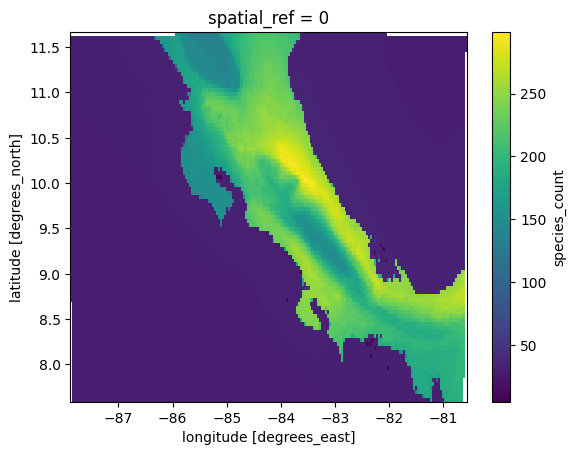

In [50]:
ord.species_count.plot()